# Figure 5

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

In [3]:
import Setup.DX_Imports as dx

importing IPython notebook from Setup/DX_Imports

Set of patients used in analysis of age advancement

In [4]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

In [5]:
sns.set_context("paper", rc={"lines.linewidth": 2.5, 
                             "font_size":14})
sns.set_style("white")

# Looking at disorder in response to age and HIV

In [6]:
keepers = fx.pred_c.index

In [7]:
mm = fx.mm
def disorder_frac(direction, beta, test_set):
    ct = pd.crosstab(beta < .5, direction.ix[test_set]>0)
    return (1.*ct[1][1] + ct[0][0]) / ct.sum().sum()

In [8]:
model_idx = fx.hannum_model.index.union(fx.horvath_model.index)
hiv_idx = ti(fx.g_hiv)
age_idx = ti(fx.g_age)

probe_sets = {'All': probe_idx, 'Models': model_idx, 'HIV': hiv_idx}

entropy_r = pd.Series({i: disorder_frac(fx.r4.multi_variate.HIV, mm, s) for i,s in 
               probe_sets.iteritems()})

probe_sets = {'All': probe_idx, 'Models': model_idx, 'Age': age_idx}

entropy_r2 = pd.Series({i: disorder_frac(fx.res.in_set_s1.multi_variate.age, mm, s) for i,s in 
               probe_sets.iteritems()})

In [9]:
entropy_r

All       0.49
HIV       0.66
Models    0.44
dtype: float64

In [10]:
entropy_r2

Age       0.70
All       0.57
Models    0.53
dtype: float64

# Screen for Epigenetic Hotspots

Here I am explicitly looking for things that trend away from 50% methylation. 

In [11]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [12]:
t_hiv = dx.ttest_df(fx.hiv == 'HIV+', fx.df_hiv)

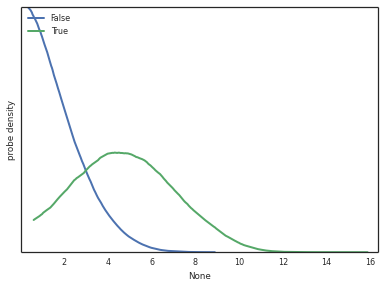

In [13]:
draw_dist(t_hiv.abs(), fx.g_hiv)

In [14]:
a,b = match_series((fx.mm > .5), (fx.r4.multi_variate.HIV < 0))
a,b = match_series(a,b)
direction = a == b

hiv_bh = fx.g_hiv
hiv_bh = (hiv_bh & (direction == False) & (fx.g_age == False)).dropna()
hiv_bh = hiv_bh.ix[probe_idx].ix[ann.index].dropna()
#hiv_bh = hiv_bh & (t_hiv.abs() > 1) 
hiv_bh.value_counts()

False    447553
True      25491
dtype: int64

In [15]:
def manhattan(vec, chrom, coords, ax=None, ybound=None,
              flow='up', ticks=True, gap=3e7):
    fig, ax = init_ax(ax, figsize=(9,3))
    x = 0
    chr_coords = []
    for i,c in enumerate(map(str, range(1,23))):
        v = vec.ix[ti(chrom == c)].dropna()
        series_scatter(coords + x, v, s=10, ax=ax, 
                       color=colors[i % 5], 
                       ann=None, alpha=1, rasterized=True) 
        chr_len = coords.ix[v.index].max()
        x = x + chr_len + gap
        chr_coords += [x - (chr_len / 2.)]
    ax.set_xbound(gap, x + gap)
    if ybound is not None:
        ax.set_ybound(ybound[0],ybound[1])
    ax.set_xlabel('Chromosome')
    
    if ticks:
        ax.set_xticks(chr_coords)
        ax.set_xticklabels(map(str, range(1,23)))
    else:
        ax.set_xticks([])
    top = flow == 'down'
    prettify_ax(ax, top)

In [16]:
hiv_bh.name = 'hit'
ann2 = ann.copy()
ann2['GC'] = np.floor(ann2.Genomic_Coordinate / 1000000)
ann2 = ann2[ann2.Chromosome.isin(map(str, range(23)))]
ann2.Chromosome = ann2.Chromosome.astype(int)
ss = ann2.groupby(['Chromosome','GC']).size()
gb = ann2.join(hiv_bh.astype(float)).groupby(['Chromosome','GC'])['hit']

In [17]:
gb.size().mean()

173.9588839941263

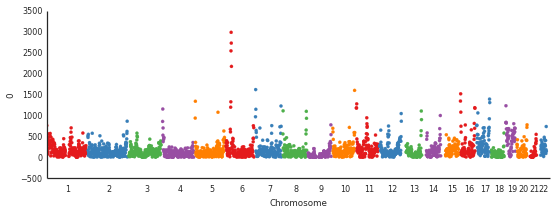

In [18]:
ss = gb.size().reset_index()
manhattan(ss[0], ss.Chromosome.astype(str), ss.GC, gap=10)

In [46]:
dd = fx.r4.multi_variate.HIV > 0
dd.name = 'up'
hiv_dx = fx.g_hiv
hiv_dx.name = 'hiv'

dx_hiv = combine(hiv_dx, dd).replace({'up':'neither','hiv':'hiv_down', 'both':'hiv_up'})
dx_hiv.value_counts()

neither     391683
hiv_down     46220
hiv_up       35141
dtype: int64

In [47]:
dd = (dx_hiv == 'hiv_down') & (fx.mm < .5) & (fx.g_age == False)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

In [19]:
m = hiv_bh.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               hiv_bh.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

### Loading in GWAS Data

In [48]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

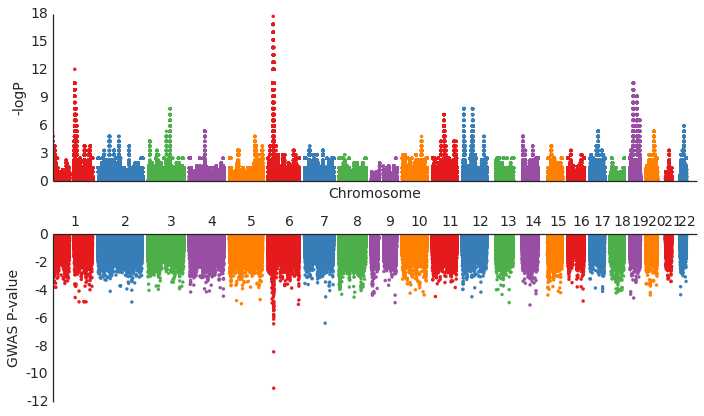

In [52]:
fig, axs = subplots(2,1, figsize=(10, 6))

ax = axs[0]
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,18], ax=ax, ticks=False)

ax.set_yticks(range(0, 19, 3))
#ax.set_yticklabels(range(0, 26, 5), size=14)
ax.set_xlabel('Chromosome', size=14)
axs[0].set_ylabel('-logP',
                  size=14)

ax = axs[1]
manhattan(-1*gwas['-logP'], gwas.chromosome, gwas.Map,
          ybound=[-12,0], ax=ax, flow='down')
ax.set_ylabel('GWAS P-value', size=14)
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_xticklabels(range(1,23), size=14)
ax.set_xlabel('')

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_cd_n.pdf', dpi=300)

Look for associations with CD4T counts of HIV-associated probes

In [53]:
df = df_hiv.ix[ti(hiv_bh.dropna())]
df = df.ix[:, keepers.intersection(ti(fx.hiv == 'HIV+'))]
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)

In [54]:
corr_with_cd4_m = screen_feature(np.log2(labs['CD4/CD8 ratio']), spearman_pandas, df,
                               align=False)

In [55]:
corr_with_cd4_m.head()

,rho,p,q
cg24351901,0.44,1.53e-07,3.55e-03
cg06872964,0.42,4.57e-07,3.55e-03
cg12752647,-0.42,5.41e-07,3.55e-03
cg15473346,0.42,5.77e-07,3.55e-03
cg23048215,0.41,1.00e-06,3.55e-03


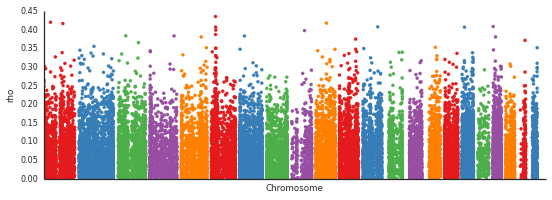

In [25]:
manhattan(corr_with_cd4_m.rho.abs(), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,.45], ticks=False)

### Zooming in on the HLA Region

In [56]:
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [57]:
m = (dx_hiv == 'hiv_down').mean()
sp.stats.binom_test(hiv_bh.ix[ti(hla_region)].sum(), 
                    n=len(hiv_bh.ix[ti(hla_region)].dropna()), p=m)

1.686692254410758e-26

In [59]:
fisher_exact_test((dx_hiv == 'hiv_down'), hla_region)

odds_ratio    1.35e+00
p             1.62e-22
dtype: float64

In [29]:
odds = pd.DataFrame({x: fisher_exact_test(hla_region, corr_with_cd4_m.rho.abs() > x)
                     for x in [.1, .15, .2, .25, .3, .35, .4]}).T
odds

,odds_ratio,p
0.10,1.01,9.34e-01
0.15,1.16,1.85e-01
0.20,1.02,9.26e-01
0.25,1.91,1.29e-02
0.30,3.00,4.85e-03
0.35,10.28,7.51e-05
0.40,11.37,2.03e-02


In [60]:
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

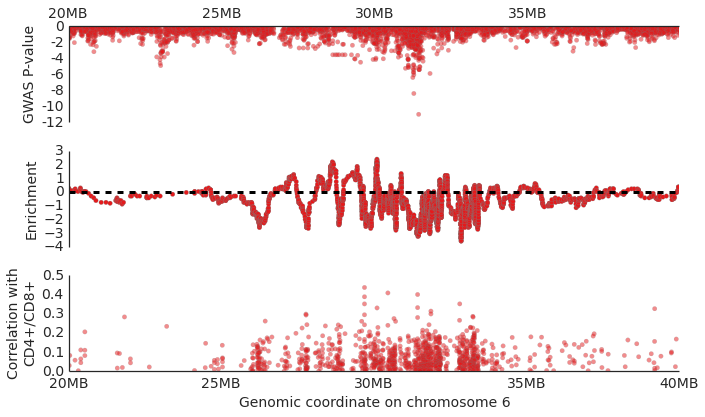

In [35]:
fig, axs  = subplots(3,1, figsize=(10,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

d = (tt[tt.abs() > 0] > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 200, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
v = (v - v.mean()) / v.std()

series_scatter(x[::5], v.ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

ax = axs[2]
series_scatter(x, corr_with_cd4_m.rho.abs(),
               ax=ax, s=20, ann=None, color=colors[0],
               edgecolor='grey')
ax.set_xbound(x.min(), x.max())
ax.set_ylim(0)
ax.set_xticks([])
ax.set_ylabel('Correlation with\nCD4+/CD8+')
ax.set_xlabel('Genomic coordinate on chromosome 6')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
ax.set_xticks(range(20000000, 41000000, 5000000))
ax.set_xticklabels(['20MB','25MB','30MB','35MB','40MB'])
prettify_ax(ax)

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_efg.pdf', dpi=300)

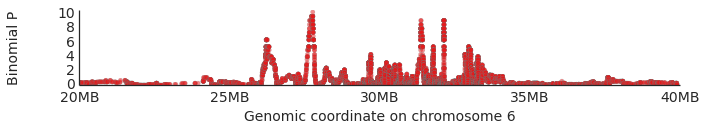

In [36]:
fig, ax  = subplots(1,1, figsize=(10,2), sharex=True)
series_scatter(x, -1*np.log10(biom_p).ix[x.index],
               ax=ax, s=20, ann=None, color=colors[0],
               edgecolor='grey')
ax.set_xbound(x.min(), x.max())
ax.set_ylim(0,10.5)
ax.set_xlabel('Genomic coordinate on chromosome 6')
ax.set_ylabel('Binomial P\n\n ')
ax.set_xbound(x.min(), x.max())
ax.set_xticks(range(20000000, 41000000, 5000000))
ax.set_xticklabels(['20MB','25MB','30MB','35MB','40MB'])
prettify_ax(ax)
fig.tight_layout()

In [38]:
full_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
histone_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 29570008)))
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [39]:
b = biom_p.ix[ti(histone_region)].order()
b.name=  'b'
ann.ix[b.index].join(b).head(10)

,Gene_Symbol,Chromosome,Genomic_Coordinate,b
Composite Element REF,,,,
cg02295525,HIST1H2AI;HIST1H2BL,6,27775480,5.25e-11
cg25108566,HIST1H2AI;HIST1H2BL,6,27775657,2.10e-10
cg22310240,HIST1H2AI;HIST1H2BL,6,27775346,2.10e-10
cg11079354,NaN,6,27740361,2.10e-10
cg04285443,HIST1H2AI,6,27774969,2.10e-10
cg09379385,HIST1H2AI,6,27774865,2.10e-10
cg15024592,NaN,6,27771383,2.10e-10
cg22257747,NaN,6,27760706,2.10e-10
cg24704603,NaN,6,27760633,2.10e-10


In [40]:
fisher_exact_test(hiv_bh, full_region)

odds_ratio    1.34e+00
p             2.11e-17
dtype: float64

In [41]:
fisher_exact_test(hla_region, hiv_bh)

odds_ratio    1.30e+00
p             7.91e-11
dtype: float64

In [42]:
fisher_exact_test(hiv_bh, histone_region)

odds_ratio    1.46e+00
p             2.88e-07
dtype: float64